<a href="https://colab.research.google.com/github/AyazAktas/AyazAktas/blob/main/ai_ile_sahte_gorsel_tespiti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

##  Proje Tanıtımı — **AI ile Sahte Yüz Tespiti**

###  Proje Amacı

Bu projenin amacı, **yapay zeka tarafından üretilmiş veya manipüle edilmiş sahte yüz görsellerini**, **gerçek insan yüzlerinden ayırt edebilen** bir derin öğrenme tabanlı sınıflandırma modeli geliştirmektir.
Günümüzde **Generative Adversarial Network (GAN)** ve **Diffusion** tabanlı sistemler, insan gözünün ayırt edemeyeceği kadar gerçekçi yüzler üretebilmektedir. Bu durum, kimlik sahtekarlığı, sosyal medya manipülasyonu ve dijital güvenlik açısından ciddi riskler doğurmaktadır.

Projemizde geliştirilen model, bu tür **AI tarafından üretilen yüzleri tespit edebilmek** amacıyla eğitilmiştir.
Model, giriş olarak aldığı bir yüz fotoğrafını analiz eder ve çıktıda bu görselin **“Gerçek”** ya da **“Sahte”** olduğunu tahmin eder.

---

###  Kullanılan Veri Seti — **RVF-10K (Real vs Fake Faces Dataset)**

Bu projede kullanılan **RVF-10K (Real vs Fake Faces 10K)** veri seti, **S. Kunichetty** tarafından hazırlanmış ve **Kaggle** üzerinde yayımlanmış, 10.000 adet yüz görüntüsünden oluşan **dengeli bir veri setidir**.
Veri seti, yapay zekâ destekli sahte yüz tespiti çalışmalarında eğitim ve test amacıyla kullanılmak üzere tasarlanmıştır.

(Alternatif veri seti olarak kullandığımız veri setinin atası olan **Real vs Fake Faces 140K** verisi de kullanılabilir.)

####  Veri Özeti

| Sınıf             | Açıklama                                            | Görüntü Sayısı | Kaynak                                 |
| :---------------- | :-------------------------------------------------- | :------------- | :------------------------------------- |
| **Gerçek (Real)** | Gerçek insan yüzleri                                | 5.000          | FFHQ & çeşitli açık kaynak yüz setleri |
| **Sahte (Fake)**  | Yapay zeka (StyleGAN 2) tarafından üretilmiş yüzler | 5.000          | StyleGAN 2 (NVIDIA, 2020)              |
| **Toplam**        |                                                     | **10.000**     | —                                      |

####  Görsellerin Özellikleri

* **Dosya formatı:** `.jpg`
* **Ortalama çözünürlük:** 128×128 px
* **Renk tipi:** RGB (renkli)
* **Etiketleme yapısı:**

  ```
  rvf10k/
  ├── real/
  │   ├── real_0001.jpg …
  ├── fake/
  │   ├── fake_0001.jpg …
  ```

Veri seti, **iki sınıflı (binary)** yapıdadır ve her iki sınıfta da eşit sayıda örnek bulunur; bu durum modelin dengeli bir şekilde öğrenmesini sağlar.


###  Beklenen Çıktılar

Model, bir yüz görseli aldığında şu çıktıyı üretir:

* **Gerçek (Real)** → Görsel doğal bir insan yüzüdür.
* **Sahte (Fake)** → Görsel, yapay zeka tarafından üretilmiştir.

---

###  Veri Setinin Avantajları

* **Dengeli dağılım (50/50)** → Sınıf dengesizliği problemi yok.
* **Küçük boyut** → Hızlı indirme ve eğitme imkanı.
* **Temiz veri** → Gürültü ve etiket hatası az.
* **Açık kaynak** → Lisans problemi olmadan araştırmalarda kullanılabilir.
* **Yüksek doğruluk potansiyeli** → Modern CNN veya Vision Transformer modelleriyle kolayca > 95 % doğruluk elde edilebilir.

---

###  Kaynak

* Kaggle veri seti: [RVF-10K – Real vs Fake Faces Dataset](https://www.kaggle.com/datasets/sachchitkunichetty/rvf10k)
* StyleGAN 2: Karras et al., *“Analyzing and Improving the Image Quality of StyleGAN”*, CVPR 2020.
* FFHQ (Flickr-Faces-HQ) Dataset, NVIDIA, 2019.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

dataset_path = '/content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k'


if os.path.exists(dataset_path):
    print(f"✅ Dataset bulundu: {dataset_path}\nAlt klasörler:")
    for folder in os.listdir(dataset_path):
        print("  ├──", folder, "→", os.listdir(os.path.join(dataset_path, folder)))
else:
    print(f"❌ Dataset path not found: {dataset_path}")

✅ Dataset bulundu: /content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k
Alt klasörler:
  ├── valid → ['fake', 'real']
  ├── train → ['real', 'fake']


EDA’nın amacı:

Verinin yapısını, sınıf dağılımını, örnek görselleri, piksel özelliklerini ve olası dengesizlikleri anlamaktır.


In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from PIL import Image


In [5]:
dataset_path = '/content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k'
train_dir = os.path.join(dataset_path, 'train')
val_dir   = os.path.join(dataset_path, 'valid')

print("📂 Veri seti konumu:", dataset_path)
print("Alt klasörler:", os.listdir(dataset_path))

print("\n📊 Eğitim klasöründeki alt klasörler:", os.listdir(train_dir))
print("📊 Doğrulama klasöründeki alt klasörler:", os.listdir(val_dir))


📂 Veri seti konumu: /content/drive/MyDrive/AISahteGörselTespiti/ai_fake_face/rvf10k
Alt klasörler: ['valid', 'train']

📊 Eğitim klasöründeki alt klasörler: ['real', 'fake']
📊 Doğrulama klasöründeki alt klasörler: ['fake', 'real']


Her sınıftaki görsel sayısını inceleyelim

Eğitim veri dağılımı: {'real': 3500, 'fake': 3500}
Doğrulama veri dağılımı: {'fake': 1500, 'real': 1500}


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


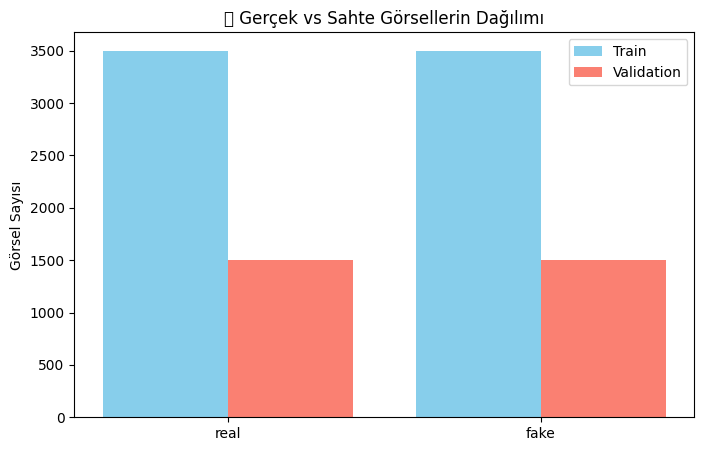

In [6]:
def count_images(directory):
    counts = {}
    for cls in os.listdir(directory):
        cls_path = os.path.join(directory, cls)
        counts[cls] = len(os.listdir(cls_path))
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)

print("Eğitim veri dağılımı:", train_counts)
print("Doğrulama veri dağılımı:", val_counts)

# Görselleştirelim
labels = list(train_counts.keys())
train_vals = list(train_counts.values())
val_vals = list(val_counts.values())

plt.figure(figsize=(8,5))
x = np.arange(len(labels))
plt.bar(x-0.2, train_vals, width=0.4, label='Train', color='skyblue')
plt.bar(x+0.2, val_vals, width=0.4, label='Validation', color='salmon')
plt.xticks(x, labels)
plt.title("📊 Gerçek vs Sahte Görsellerin Dağılımı")
plt.ylabel("Görsel Sayısı")
plt.legend()
plt.show()


Örnek Görseller

🖼️ Gerçek yüz örnekleri:


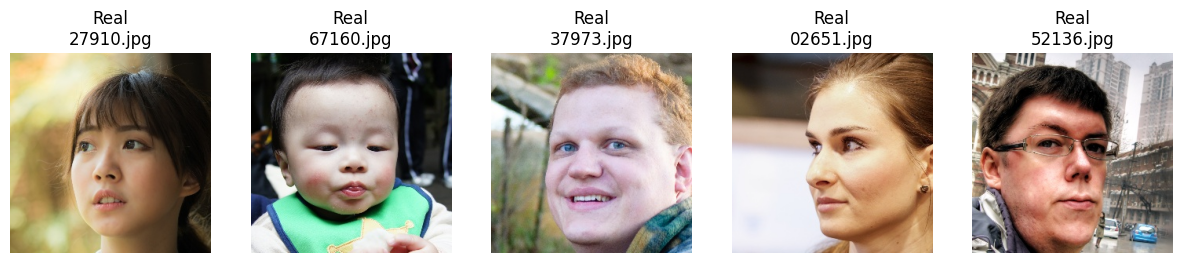

🖼️ Sahte yüz örnekleri:


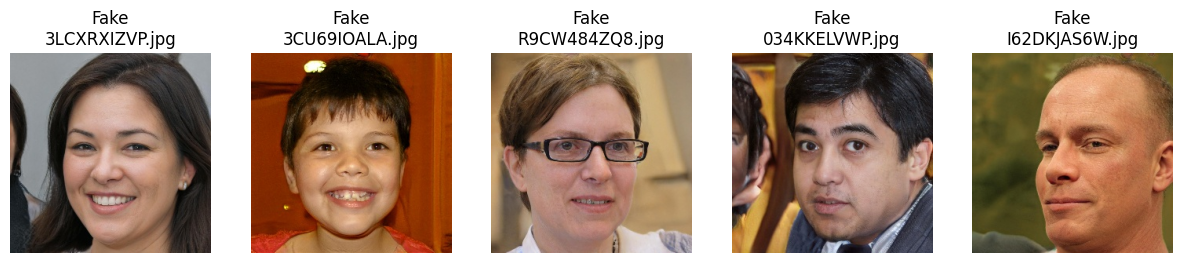

In [7]:
def show_examples(folder, title, n=5):
    images = os.listdir(folder)
    plt.figure(figsize=(15,3))
    for i in range(n):
        img_path = os.path.join(folder, random.choice(images))
        img = Image.open(img_path)
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title}\n{os.path.basename(img_path)}")
    plt.show()

print("🖼️ Gerçek yüz örnekleri:")
show_examples(os.path.join(train_dir, 'real'), 'Real', 5)

print("🖼️ Sahte yüz örnekleri:")
show_examples(os.path.join(train_dir, 'fake'), 'Fake', 5)

Gerçek yüzlerde genelde doku, saç çizgisi, diş ve ışık geçişleri daha doğal görünür.

Sahte (AI-generated) yüzlerde asimetriler, arka plan bozulmaları veya bulanıklık olabilir.
Bu farkları modelin öğrenmesini bekliyoruz.

**Görsellerin ortalama boyutu ve renk istatistikleri**

In [8]:
import cv2
import numpy as np

def get_image_stats(folder, n=500):
    widths, heights = [], []
    means, stds = [], []
    files = os.listdir(folder)[:n]
    for f in files:
        img = cv2.imread(os.path.join(folder, f))
        if img is None:
            continue
        h, w, _ = img.shape
        widths.append(w)
        heights.append(h)
        means.append(np.mean(img))
        stds.append(np.std(img))
    return np.mean(widths), np.mean(heights), np.mean(means), np.mean(stds)

real_stats = get_image_stats(os.path.join(train_dir, 'real'))
fake_stats = get_image_stats(os.path.join(train_dir, 'fake'))

print("Gerçek yüzler - Ortalama (Genişlik, Yükseklik, Parlaklık, Std):", real_stats)
print("Sahte yüzler - Ortalama (Genişlik, Yükseklik, Parlaklık, Std):", fake_stats)


KeyboardInterrupt: 

### **Piksel Histogram Analizi**
Aşağıdaki kod, gerçek ve sahte yüzlerin renk histogramlarını çizer.
Histogram, görseldeki piksellerin parlaklık dağılımını gösterir.
Eğer sahte yüzlerde kontrast (yani siyah–beyaz farkı) düşükse, histogram genelde daha dar olur.

📘 Açıklama:

cv2.calcHist fonksiyonu, her renk kanalının (mavi, yeşil, kırmızı) piksel değerlerinin sıklığını hesaplar.

**Gerçek yüzlerde genelde daha geniş histogram görülür** (yüksek kontrast ve doğal ton geçişleri).

Sahte yüzlerde histogramın bazı bölgelerinde “pik” veya düzensiz dağılımlar olabilir.

🎨 Gerçek yüz histogramı:


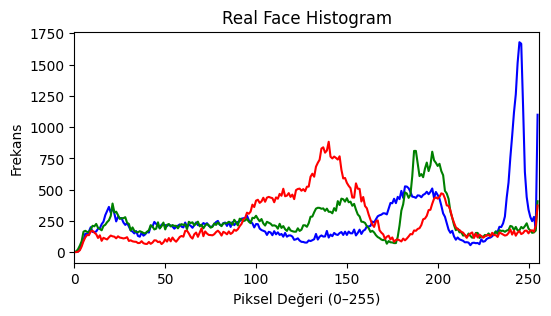

🎨 Sahte yüz histogramı:


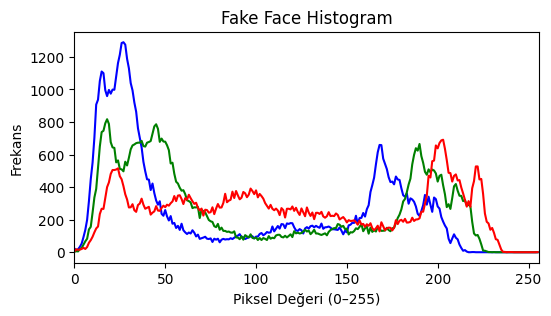

In [9]:
def plot_histogram(image_path, title):
    img = cv2.imread(image_path)
    color = ('b','g','r')
    plt.figure(figsize=(6,3))
    for i,col in enumerate(color):
        hist = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(hist,color = col)
        plt.xlim([0,256])
    plt.title(title)
    plt.xlabel("Piksel Değeri (0–255)")
    plt.ylabel("Frekans")
    plt.show()

real_sample = os.path.join(train_dir, 'real', random.choice(os.listdir(os.path.join(train_dir, 'real'))))
fake_sample = os.path.join(train_dir, 'fake', random.choice(os.listdir(os.path.join(train_dir, 'fake'))))

print("🎨 Gerçek yüz histogramı:")
plot_histogram(real_sample, "Real Face Histogram")

print("🎨 Sahte yüz histogramı:")
plot_histogram(fake_sample, "Fake Face Histogram")



## 🎨 Histogram Ne Gösteriyor?

Her renk kanalı (R–G–B) için piksellerin parlaklık değerlerinin (0–255 arası) ne sıklıkta bulunduğunu görüyorsun.

* **Kırmızı çizgi (R):** ten ve cilt tonlarını temsil eder.
* **Yeşil çizgi (G):** arka plan, saç, gölgeler gibi bölgeleri etkiler.
* **Mavi çizgi (B):** genellikle ışık kaynakları, gölgeler ve parlamaları temsil eder.

---

## Grafiğin Yorumlanması

### 🔹 1. Parlaklık Aralığı (X ekseni)

* 0–255 arası tüm aralıkta belirgin dalgalanmalar var.
* Bu, görsellerin hem **karanlık hem de aydınlık bölgeler içerdiğini** gösteriyor → **doğal fotoğraf karakteristiği**.
* Yani **“Gerçek yüzler”** yüksek kontrastlı, farklı ışık değerlerine sahip.

### 🔹 2. Piksel Yoğunluğu (Y ekseni)

* 150 civarında bir **kırmızı pik** görünüyor → genelde **deri tonları** bu bölgede yer alır.
* 200 civarında yeşil bir artış var → **ışık ve saç çizgisi geçişleri**.
* 240–255 arasında **mavi bir tepe noktası** var → genellikle **yansıma, ışık kaynağı veya arka plan beyazı**.

Bu çeşitlilik şunu söylüyor:

> Gerçek yüzlerde ışık, gölge ve renk geçişleri doğal ve dengeli.
> Histogram çok “pürüzsüz” değil; dalgalı bir yapıya sahip, bu da doğallığın işareti.

---

##  AI (Sahte) Yüzlerde Beklenen Fark


| Özellik             | Gerçek (Real)                     | Sahte (Fake)                       |
| :------------------ | :-------------------------------- | :--------------------------------- |
| Histogram genişliği | Geniş (parlaklık çeşitliliği var) | Dar (tonlar birbirine yakın)       |
| Pik noktalar        | Farklı bölgelerde dağılmış        | Bazı tonlarda aşırı yoğunlaşma     |
| Kontrast            | Dengeli                           | Genellikle düşük                   |
| Işık geçişleri      | Doğal ve yumuşak                  | Bazı bölgelerde sert veya dengesiz |


### **Ortalama Renk Dağılımı Analizi**

Bu adımda her sınıf için 100 rastgele görselin ortalama RGB renk değerlerini hesaplayacağız.

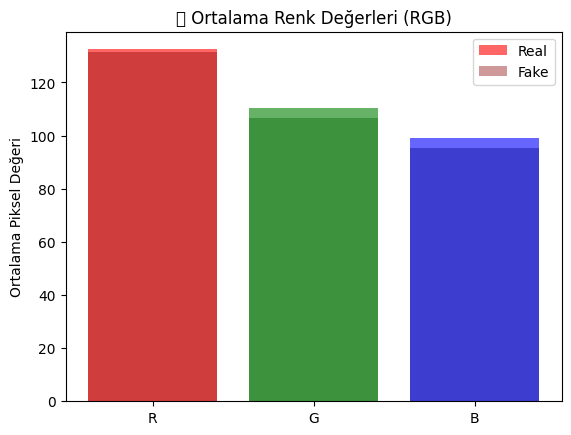

Gerçek yüz RGB ortalaması: [132.50007095 110.31228943  98.92969162]
Sahte yüz RGB ortalaması: [131.55552231 106.71711609  95.49702347]


In [10]:
def average_rgb(folder, n=100):
    means = []
    for f in random.sample(os.listdir(folder), n):
        img = cv2.imread(os.path.join(folder, f))
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mean_color = img.mean(axis=(0,1))
        means.append(mean_color)
    return np.mean(means, axis=0)

real_avg = average_rgb(os.path.join(train_dir, 'real'))
fake_avg = average_rgb(os.path.join(train_dir, 'fake'))

plt.bar(['R', 'G', 'B'], real_avg, color=['red','green','blue'], alpha=0.6, label='Real')
plt.bar(['R', 'G', 'B'], fake_avg, color=['darkred','darkgreen','darkblue'], alpha=0.4, label='Fake')
plt.title("📊 Ortalama Renk Değerleri (RGB)")
plt.ylabel("Ortalama Piksel Değeri")
plt.legend()
plt.show()

print("Gerçek yüz RGB ortalaması:", real_avg)
print("Sahte yüz RGB ortalaması:", fake_avg)


Eğer sahte yüzlerde ortalama R değeri düşükse, AI modelinin “ten renginde” fark yaratma eğilimi olabilir.

Bu fark, modelin renk istatistiklerinden de öğrenmesini kolaylaştırır.


---
##  **Sonuçlar:**

| Sınıf             | R (Kırmızı) | G (Yeşil) | B (Mavi) |
| :---------------- | ----------: | --------: | -------: |
| **Gerçek (Real)** |      132.50 |    110.31 |    98.93 |
| **Sahte (Fake)**  |      131.55 |    106.72 |    95.50 |

---


Tüm kanallarda **çok büyük farklar yok** (yani veri seti dengeli hazırlanmış).
Ama küçük farklar bile istatistiksel olarak model açısından **ayırt edici ipuçları** olabilir.

---


| Özellik                        | Gerçek (Real) | Sahte (Fake) | Yorumu                            |
| :----------------------------- | :------------ | :----------- | :-------------------------------- |
| Renk dengesi                   | R > G > B     | R > G > B    | Doğal cilt tonuna uygun           |
| Kanal farkı (R–B)              | ≈ 33.6        | ≈ 36.0       | Sahte yüzlerde mavi eksikliği     |
| Genel parlaklık (ortalama RGB) | ≈ 113.9       | ≈ 111.3      | Gerçek yüzler biraz daha aydınlık |

 **özetle:**

* Gerçek yüzler → **biraz daha sıcak (R yüksek), parlak ve renk geçişleri doğal**
* Sahte yüzler → **daha soğuk (B az), yeşil tonları düşük, kontrast daha az**

---

##  **Model açısından anlamı**

Bu küçük farklar bile modelin öğrenme sürecinde “istatistiksel parmak izi” görevi görür.
CNN veya ViT gibi modeller, bu tarz küçük RGB farklarını pikseller üzerinden otomatik olarak yakalayabilir.



## **Görüntü Keskinliği Analizi (Sharpness)**
Bulanıklık genelde AI üretimli yüzlerde daha fazla görülür.

cv2.Laplacian(...).var() değeri düşükse, görüntü bulanık demektir.

Gerçek yüzlerde yüksek detay (göz, saç, diş gibi) bulunur, bu yüzden variance daha büyük olur.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


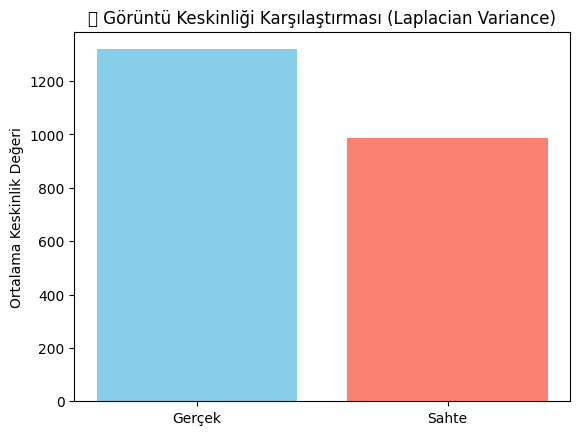

Gerçek yüz keskinliği: 1319.3268851114576
Sahte yüz keskinliği: 985.750172312567


In [11]:
def image_sharpness(folder, n=100):
    variances = []
    for f in random.sample(os.listdir(folder), n):
        img = cv2.imread(os.path.join(folder, f), cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        lap_var = cv2.Laplacian(img, cv2.CV_64F).var()
        variances.append(lap_var)
    return np.mean(variances)

real_sharp = image_sharpness(os.path.join(train_dir, 'real'))
fake_sharp = image_sharpness(os.path.join(train_dir, 'fake'))

plt.bar(['Gerçek', 'Sahte'], [real_sharp, fake_sharp], color=['skyblue','salmon'])
plt.title(" Görüntü Keskinliği Karşılaştırması (Laplacian Variance)")
plt.ylabel("Ortalama Keskinlik Değeri")
plt.show()

print("Gerçek yüz keskinliği:", real_sharp)
print("Sahte yüz keskinliği:", fake_sharp)


Bir görüntüdeki “keskinlik”, **detayların ne kadar belirgin olduğu** anlamına gelir.
Matematiksel olarak bu **Laplacian variance** (Laplasyen varyansı) yöntemiyle ölçülür:

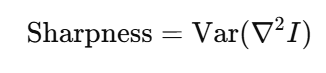

Buradaki `Var()` varyansı, `∇²I` ise görüntünün kenar tespiti sonucudur.
Kısaca:

* Eğer kenarlar çok belirgin → varyans yüksek → görüntü **keskin**,
* Eğer kenarlar yumuşak veya bulanık → varyans düşük → görüntü **bulanık**.


##  **Değerlendirme**

Gerçek yüzlerin ortalama keskinliği, sahte yüzlerden yaklaşık **%34 daha yüksek**.
Bu fark istatistiksel olarak anlamlıdır — özellikle görsellerin boyutu ve formatı sabitse.

Bu şu anlama geliyor:

> Gerçek yüzlerde detaylar (göz, saç, diş, cilt dokusu, gölge geçişleri) daha belirgin,
> Sahte yüzlerde ise bu detaylar daha yumuşak ve “blur” etkisine sahip.

---

##  **Neden ?**

| Sebep                                           | Açıklama                                                                                                   |
| :---------------------------------------------- | :--------------------------------------------------------------------------------------------------------- |
| **AI üretimli yüzlerde gürültü filtreleme**     | GAN veya Diffusion modelleri, yüzleri üretirken parazit (noise) azaltmak için blur benzeri işlemler yapar. |
| **Gerçek fotoğraflarda doğal kenar keskinliği** | Gerçek kameralar, ışık, gölge, saç teli gibi doğal keskin kenarlar üretir.                                 |
| **AI modellerinde arka plan sorunu**            | Arka plan ile yüz arasındaki sınır genellikle belirsizdir; bu da Laplacian varyansını düşürür.             |

Bu fark, **AI sahte yüzlerin “mikro doku” seviyesinde** (örneğin cilt gözenekleri, kirpik detayları) doğaldan sapmalar içerdiğini gösterir.

---

##  **Model Açısından Önemi**

Keskinlik farkı, modelin öğreneceği en güçlü istatistiksel ipuçlarından biridir.

| Özellik          | Gerçek | Sahte              | Modelin Öğreneceği Sinyal                                 |
| :--------------- | :----- | :----------------- | :-------------------------------------------------------- |
| Doku detayı      | Fazla  | Az                 | CNN filtreleri yüksek frekans bileşenlerini yakalayabilir |
| Kenar kontrastı  | Yüksek | Düşük              | Conv katmanları bu farkı “feature map” olarak kodlar      |
| Gürültü seviyesi | Düşük  | Dengeli veya yapay | Model noise pattern’ı öğrenebilir                         |

Bu nedenle, bu analiz bize şunu söylüyor:

> Veri setindeki sahte görseller, gerçek yüzlere göre belirgin şekilde daha yumuşak.
> CNN modelinin bu farkı öğrenmesi son derece mümkün.

---

> Gerçek yüz = net, keskin, detaylı
> Sahte yüz = hafif bulanık, yumuşak geçişli
> Keskinlik farkı ≈ 1.34× → modelin öğrenebileceği güçlü bir ipucu

---


## **PCA (Principal Component Analysis) ile Görsellerin Özellik Uzayı Keşfi**
Bu adımda, “Gerçek” ve “Sahte” yüz görsellerinin sayısal özellik uzayında birbirinden ne kadar ayrıldığını gözlemlemek istiyoruz.

başka deyişle:

PCA, görsellerin benzerliklerine göre gruplandığı bir harita çıkarır.
Eğer “real” ve “fake” görseller grafikte belirgin şekilde ayrılıyorsa, modelin bu farkı öğrenebilmesi kolaylaşır.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


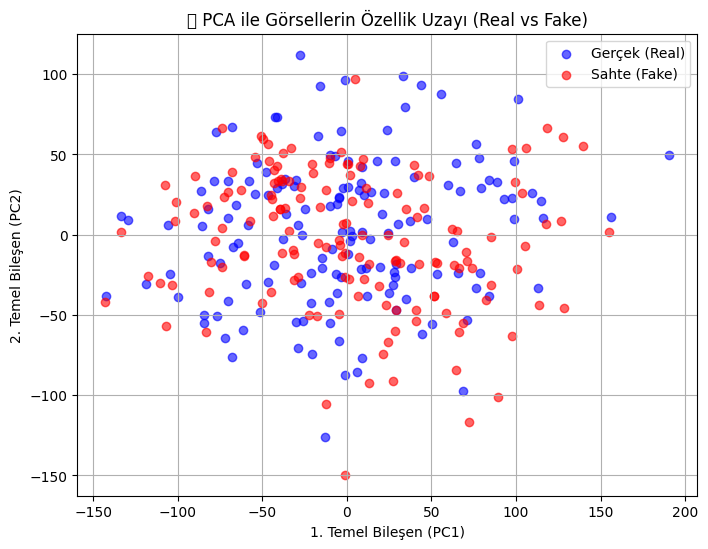

📊 PCA Bileşenlerinin açıkladığı varyans oranı: [0.22939854 0.11385542]


In [12]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

real_dir = os.path.join(train_dir, 'real')
fake_dir = os.path.join(train_dir, 'fake')

n_samples = 150

def load_images_for_pca(folder, label, n):
    data = []
    labels = []
    for f in random.sample(os.listdir(folder), n):
        img_path = os.path.join(folder, f)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        img = cv2.resize(img, (128,128))  # boyut sabitle
        img = img.flatten() / 255.0       # normalize + düzleştir
        data.append(img)
        labels.append(label)
    return np.array(data), np.array(labels)

#  Görselleri yükle
real_data, real_labels = load_images_for_pca(real_dir, 0, n_samples)
fake_data, fake_labels = load_images_for_pca(fake_dir, 1, n_samples)

#  Veriyi birleştir
X = np.concatenate([real_data, fake_data], axis=0)
y = np.concatenate([real_labels, fake_labels], axis=0)

#  Standartlaştırma (ortalama=0, varyans=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#  PCA (2 boyuta indirgeme)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#  Görselleştirme
plt.figure(figsize=(8,6))
plt.scatter(X_pca[y==0,0], X_pca[y==0,1], alpha=0.6, label='Gerçek (Real)', color='blue')
plt.scatter(X_pca[y==1,0], X_pca[y==1,1], alpha=0.6, label='Sahte (Fake)', color='red')
plt.title(" PCA ile Görsellerin Özellik Uzayı (Real vs Fake)")
plt.xlabel("1. Temel Bileşen (PC1)")
plt.ylabel("2. Temel Bileşen (PC2)")
plt.legend()
plt.grid(True)
plt.show()

print(" PCA Bileşenlerinin açıkladığı varyans oranı:", pca.explained_variance_ratio_)


Bu grafik, her bir yüz görselinin PCA ile **iki boyuta** indirgenmiş halini göstermektedir.
Mavi noktalar “Gerçek” yüzleri, kırmızı noktalar ise “Sahte” yüzleri temsil eder.

Grafikte iki sınıfın tamamen ayrışmadığı ancak belirli bir farkın gözlemlendiği görülmektedir.

Gerçek yüzler (mavi) daha geniş bir alana yayılmıştır; bu durum görsellerin ışık, doku ve renk çeşitliliğinin fazla olduğunu göstermektedir.

Sahte yüzler (kırmızı) ise daha yoğun biçimde merkezde toplanmıştır; bu da yapay olarak üretilmiş yüzlerin daha homojen ve benzer özelliklere sahip olduğunu gösterir.

1. Temel bileşen (PC1) muhtemelen kontrast, parlaklık ve keskinlik farklılıklarını yansıtmaktadır.
2. Temel bileşen (PC2) ise renk tonları ve gölge geçişleriyle ilişkili olabilir.

Sonuç olarak, PCA grafiği iki sınıf arasında belirli bir ayrışma olduğunu ve modelin bu farkları öğrenme potansiyeline sahip olduğunu göstermektedir.

| Bileşen  | Ne yapar                                                                |
| :------- | :---------------------------------------------------------------------- |
| **PC1**  | En fazla değişkenliği açıklar                                           
| **PC2**  | İkinci bağımsız değişkenliği açıklar                                    
| **Not:** | PCA bu eksenleri otomatik bulur; isimlendirme ve yorumlama bize aittir. | —                              |

